In [1]:
using Pkg
Pkg.add("DifferentialEquations")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed OrdinaryDiffEqRKN ─────────────────── v1.5.0
   Installed AlmostBlockDiagonals ──────────────── v0.1.10
   Installed BoundaryValueDiffEqFIRK ───────────── v1.9.0
   Installed DifferentialEquations ─────────────── v7.16.1
   Installed FastGaussQuadrature ───────────────── v1.1.0
   Installed OrdinaryDiffEqRosenbrock ──────────── v1.18.1
   Installed OrdinaryDiffEqStabilizedRK ────────── v1.4.0
   Installed NonlinearSolve ────────────────────── v4.12.0
   Installed OrdinaryDiffEqPRK ─────────────────── v1.4.0
   Installed EnumX ─────────────────────────────── v1.0.5
   Installed BoundaryValueDiffEqMIRK ───────────── v1.9.0
   Installed Sundials_jll ──────────────────────── v5.2.3+0
   Installed SciMLJacobianOperators ────────────── v0.1.11
   Installed OrdinaryDiffEqSDIRK ───────────────── v1.7.0
   Installed Polyester ─────────────────────────── v0.7.18
   Installed RecursiveArrayTo

In [29]:
using Random, Dates
timestamp = Dates.now()
seed = Int(floor(Dates.datetime2unix(timestamp)))
Random.seed!(seed)


TaskLocalRNG()

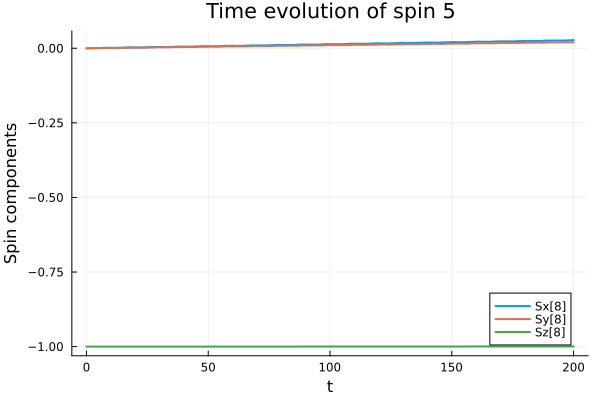

In [113]:
using DifferentialEquations
using LinearAlgebra
using Random

function heisenberg_chain(dS, S, p, t)
    N, J = p

    S_mat = reshape(S, (3, N))
    dS_mat = reshape(dS, (3, N))

    # Periodic boundary conditions
    for i in 1:N
        ip1 = i == N ? 1 : i + 1
        im1 = i == 1 ? N : i - 1
        local_field = J * (S_mat[:, im1] + S_mat[:, ip1])
        dS_mat[:, i] .= -cross(S_mat[:, i], local_field) ## Ferromagnetic coupling
    end
end


N = 20          
J = 1.0         
p = (N, J)
tspan = (0.0, 200.0)

"""
# Ferromagnetic initial state
S0 = [0.0  for i in 1:N, j in 1:3]'
S0[3, :] .= 1.0  
"""



# AFM initial state
S0 = zeros(3, N)
for i in 1:N
    if isodd(i)
        S0[:, i] = [0.0, 0.0, 1.0]   
    else
        S0[:, i] = [0.0, 0.0, -1.0]  
    end
end



# perturbation around inital state
ϵ = 1e-4
for i in 1:N
    S0[:, i] .+= ϵ * randn(3)
    S0[:, i] ./= norm(S0[:, i])   
end


"""
## Random inital state
S0 = randn(3, N)
for i in 1:N
    S0[:, i] ./= norm(S0[:, i])
end
"""


S0_vec = vec(S0);  


prob = ODEProblem(heisenberg_chain, S0_vec, tspan, p);
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6);

using Plots

ith_spin = 8

t = sol.t
S_i = [reshape(sol.u[k], (3, N))[:, ith_spin] for k in 1:length(sol)]
Sx = [s[1] for s in S_i]
Sy = [s[2] for s in S_i]
Sz = [s[3] for s in S_i]

# Plot components over time
plot(t, Sx, label="Sx[$ith_spin]", lw=2)
plot!(t, Sy, label="Sy[$ith_spin]", lw=2)
plot!(t, Sz, label="Sz[$ith_spin]", lw=2)
xlabel!("t")
ylabel!("Spin components")
title!("Time evolution of spin $i_spin")

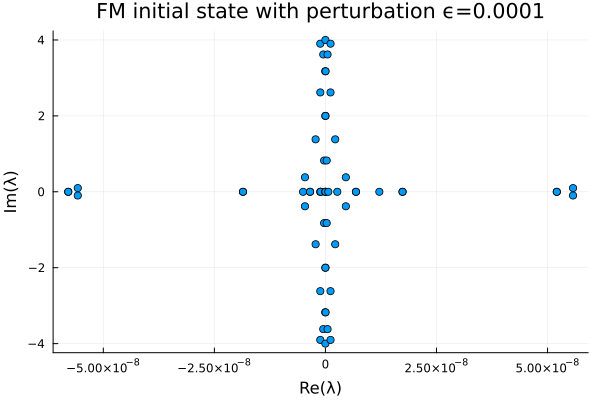

In [83]:
function jacobian_heisenberg(S0, N, J; δ=0.05)
    f0 = zeros(3N)
    heisenberg_chain(f0, vec(S0), (N, J), 0.0)
    Jmat = zeros(3N, 3N)
    for j in 1:3N
        Spert = copy(vec(S0))
        Spert[j] += δ
        f1 = zeros(3N)
        heisenberg_chain(f1, Spert, (N, J), 0.0)
        Jmat[:, j] .= (f1 - f0) / δ
    end
    return Jmat
end

function stability_analysis(S0, N, J)
    Jmat = jacobian_heisenberg(S0, N, J)
    eigs = eigvals(Jmat)
    max_real = maximum(real.(eigs))
    return eigs
end

eigs = stability_analysis(S0, N, J)

scatter(real.(eigs), imag.(eigs),
    xlabel="Re(λ)", ylabel="Im(λ)", title="FM initial state with perturbation ϵ=$ϵ",
    legend=false)

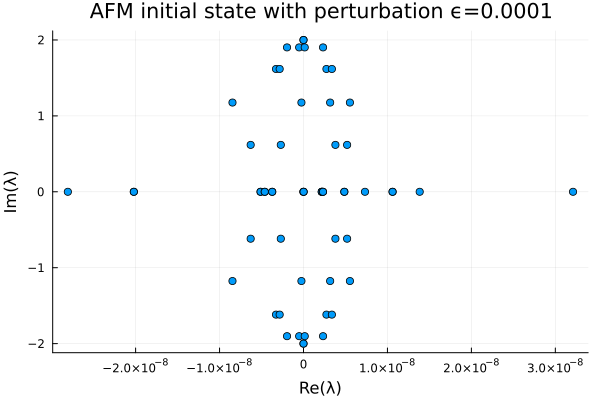

In [85]:
function jacobian_heisenberg(S0, N, J; δ=0.05)
    f0 = zeros(3N)
    heisenberg_chain(f0, vec(S0), (N, J), 0.0)
    Jmat = zeros(3N, 3N)
    for j in 1:3N
        Spert = copy(vec(S0))
        Spert[j] += δ
        f1 = zeros(3N)
        heisenberg_chain(f1, Spert, (N, J), 0.0)
        Jmat[:, j] .= (f1 - f0) / δ
    end
    return Jmat
end

function stability_analysis(S0, N, J)
    Jmat = jacobian_heisenberg(S0, N, J)
    eigs = eigvals(Jmat)
    max_real = maximum(real.(eigs))
    return eigs
end

eigs = stability_analysis(S0, N, J)

scatter(real.(eigs), imag.(eigs),
    xlabel="Re(λ)", ylabel="Im(λ)", title="AFM initial state with perturbation ϵ=$ϵ",
    legend=false)

## Lyapunov expoenents - Subroto Mukherjee

In [100]:
N = 10

S0 = zeros(3, N)
for i in 1:N
    if isodd(i)
        S0[:, i] = [0.0, 0.0, 1.0]   
    else
        S0[:, i] = [0.0, 0.0, -1.0]  
    end
end

S0
#vec(S0)

3×10 Matrix{Float64}:
 0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0
 0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0
 1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0  1.0  -1.0

In [103]:
S0[3,3]

1.0

In [114]:
using DifferentialEquations, LinearAlgebra, Random

function lyapunov_exponents(N, J; T=100.0, dt=0.01, δ=1e-6)
    
    # --- AFM initial state ---
    S0 = zeros(3, N)
    for i in 1:N
        if isodd(i)
            S0[:, i] = [0.0, 0.0, 1.0]   
        else
            S0[:, i] = [0.0, 0.0, -1.0]  
        end
    end
    
    num_steps = Int(T / dt)
    dim = 3N

    # Allocate arrays (no longer 3×N indexing)
    deltax_ij = zeros(dim)
    lambda_ij = zeros(dim)
    S = copy(S0)

    for step in 1:num_steps
        prob = ODEProblem(heisenberg_chain, vec(S), (0.0, dt), (N, J))
        sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6)
        S = reshape(sol.u[end], (3, N))

        # Evolve perturbations
        δS = δ * randn(dim)  # Flattened perturbation
        S_pert = vec(S) .+ δS

        prob_pert = ODEProblem(heisenberg_chain, S_pert, (0.0, dt), (N, J))
        sol_pert = solve(prob_pert, Tsit5(), reltol=1e-6, abstol=1e-6)
        S_pert_final = sol_pert.u[end]

        # Compute deviation
        deltax_ij .= S_pert_final .- vec(S)

        # Compute Lyapunov "growth" per component
        lambda_ij .= log.(abs.(deltax_ij) ./ δ) ./ T
    end

    return lambda_ij
end

lyapunov_exponents (generic function with 2 methods)

In [115]:
lyapunov_exponents(100, 1.0)

300-element Vector{Float64}:
 -0.008401475926935641
 -0.011443820530730928
  0.004185751423931136
  0.004139089771893338
 -0.015958181638599134
 -0.003654034471489418
 -0.0302387245277685
  0.0023295545220806428
 -0.004815363031082845
 -0.014245101765409758
 -0.0056853399284029285
  0.004186495430988261
 -0.016165076159999524
  ⋮
 -0.0029228772936080215
 -0.028701111135703908
 -0.0027446504395319694
 -0.026933997147263487
  0.00013376226753114976
 -0.006995906042355705
 -0.0011645200683797938
 -0.00852550860505228
 -0.03023828225314443
 -0.02549527484221306
 -0.022331605541167244
 -0.006805464402441381